## Using CuPy + NVIDIA GPUs to Accelerate your Python/Numpy Code
#### Fractal Generation 

Creating fractals is a fun way to demonstrate the power of CuPy, a GPU-accelerated clone of Numpy.  Most of Numpy's functionality is replicated in CuPy, allowing you to replace most instances of `np` in your code with `cp` to use the GPU-accelerated versions.  CuPy is also interoperable with the [RAPIDS](https://rapids.ai) ecosystem, which has GPU-accelerated versions of Pandas (cuDF), Scikit-Learn (cuML) and NetworkX (cuGraph).  All four of these libraries are super powerful though we are only going over CuPy (`cp`) in this notebook.

See my [related blog post](https://blog.alanreiner.com/2023/09/06/10000x-fractal-speed-using-python-cupy/).

In this notebook we will:

* Demonstrate how easy it is to write custom CUDA kernels with CuPy
* Demonstrate the absurd speedups you can get on fractal generation
* Generate fractals fast enough to make interactive visuals
* Combine the above with CuPy FFTs to do fractal searches
* Generate a zooming Julia Set animation

**NOTE**: All this fractal generation code should work fine in Colab, but the interactive visualizations **will not**.  Colab it has a different widget/interaction system than Jupyter.  I ran this on a Linux desktop using JupyterLab 3.0 with the `mpl_interactions` package.  See `requirements.txt`. 

### Hardware 

This notebook and the published timings were based on an **NVIDIA GeForce RTX 3090** GPU, and **AMD Ryzen 3 5800X** CPU.  This will work with any CPU and any modern NVIDIA GPU, though you should expect different timings.

CuPy claims to have [experimental support for AMD GPUs using ROCm](https://docs.cupy.dev/en/stable/install.html#using-cupy-on-amd-gpu-experimental) but I have no experience with it.  Good luck!

### Background - Julia Sets

[Julia sets](https://en.wikipedia.org/wiki/Julia_set) are fractals based on simple mathematical constructs of complex numbers that produce surprisingly unintutive geometric patterns.  Most interestingly, they have infinite resolution as seen in the following .gif that was generated at the end of this notebook.

![](./visuals/julia_zoom.gif)

With an arbitrary-width floating-point datatype, you could zoom as far into this fractal as you want.


### Summary of findings aggregated from running the notebook.
-----
NOTE: The Python & C++ implementations are dumb & naive.  They could probably be optimized to run faster -- but would still never catch up...

| Fractal Timings    | Frames/Sec |
| ----------- |  ------- |
| Python (naive)      |   0.17 FPS |
| C++ (CPU,naive)   |  10.1 FPS |
| CuPy (xfer off GPU) | 2,171 FPS |
| CuPy (stay on GPU) |  24,389 FPS|

-----

In the second half of the notebook, we use FFTs to produce spectrograms to try to find interesting fractals.  It's worth knowing that CuPy has pretty efficient FFTs as well, and the ~50x is a much more typical speedup for this kind of GPU-acceleration.

| FFT Timings      | Time per FFT (768x768) | Frames/Sec |
| ----------- | ----------- | ------ |
| CPU (Numpy) 2D FFT | 0.00974 sec |  103 FPS |
| GPU (CuPy) 2D FFT (xfer to CPU) | 0.00233 sec | 429 FPS |
| GPU (CuPy) 2D FFT (stay on GPU) | 0.00020 sec |  5,000 FPS |
| ----------- | ----------- | ------ |
| GPU Fractal + FFT + Reduce | 0.00097 sec | 1,036 FPS |

-----

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_interactions import ipyplot as iplt

import nb_utils # some verbose helper methods that were bloating the notebook
from nb_utils import SimpleTimers

In [3]:
# Different interactive widget systems.  One of these might work in your Jupyter notebook for the interactive fractals (will NOT work in Colab)
%matplotlib ipympl
#%matplotlib widget

-----

## 1. CuPy's Hello World (matrix-multiply-add on the GPU)

Let's make sure CuPy was installed and imported properly and finds our GPU.  Run a quick speed test.  See also: [Basics of CuPy](https://docs.cupy.dev/en/stable/user_guide/basic.html#how-to-write-cpu-gpu-agnostic-code)

In [4]:
# Generates a 8192x8192 matrix of random numbers on the GPU.  
test_size = 8192
cupy_mtrx = cp.random.normal(size=(1, test_size*test_size))
cupy_mtrx = cupy_mtrx.reshape((test_size, test_size)) * 0.5

print('CuPy Matrix Size:    ', cupy_mtrx.shape)
print('CuPy Matrix Device:  ', str(cupy_mtrx.device))

CuPy Matrix Size:     (8192, 8192)
CuPy Matrix Device:   <CUDA Device 0>


In [5]:
# Generate 3 unique matrices to use 
a_gpu = cupy_mtrx.copy()
b_gpu = cupy_mtrx.copy() * 0.5
c_gpu = cp.ones_like(a_gpu)

n_iter = 100
with SimpleTimers.new('gpu-mtrx-multiply-add', n_iter):
    for _ in range(n_iter):
        a_gpu = (a_gpu @ b_gpu + c_gpu) / 16

Timings (gpu-mtrx-multiply-add):
  100 iterations in 2.710 seconds
  36.8979 iter/sec
  0.02710 sec/iter


### Measure Same Numpy ops

In [6]:
# Generate random 2D array on CPU
numpy_mtrx = np.random.normal(size=(1, test_size*test_size))
numpy_mtrx = numpy_mtrx.reshape((test_size, test_size)) * 0.5

a_cpu = numpy_mtrx.copy()
b_cpu = numpy_mtrx.copy() * 0.5
c_cpu = np.ones_like(a_cpu) 

n_iter=2
with SimpleTimers.new('cpu-mtrx-multiply-add', n_iter):
    for _ in range(n_iter):
        #a_cpu = a_cpu @ b_cpu + c_cpu
        a_cpu = np.matmul(a_cpu, b_cpu) + c_cpu

Timings (cpu-mtrx-multiply-add):
  2 iterations in 5.587 seconds
  0.3580 iter/sec
  2.79368 sec/iter


GPU (CuPy) Speedup over CPU (Numpy) for 8192x8192 matrices: 103.08x


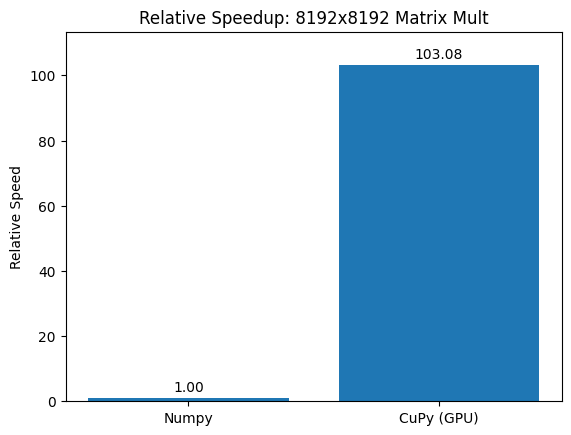

In [7]:
# My SimpleTimers class makes it easy to get previous timings and compare
gpu_speed = SimpleTimers.get_iter_per_sec('gpu-mtrx-multiply-add')
cpu_speed = SimpleTimers.get_iter_per_sec('cpu-mtrx-multiply-add')
speed_ratio = gpu_speed / cpu_speed
print(f'GPU (CuPy) Speedup over CPU (Numpy) for {test_size}x{test_size} matrices: {speed_ratio:.2f}x')

nb_utils.plot_bars_speedup(['Numpy', 'CuPy (GPU)'],
                           [1, speed_ratio],
                           f'Relative Speedup: {test_size}x{test_size} Matrix Mult')

**With HUGE matrices, you get very impressive speedups using CuPy/GPU.**

# 2. Julia Set Generation Code - CPU

We need to calculate the "escape time" for complex values between -2-2i and +2+2i.  We will discretize the complex plane into a 768x768 grid for this.


In [4]:
SIZE=768
EPS=1e-6

zmesh_real, zmesh_imag = np.meshgrid( 
    np.arange(-2, 2, (4 + EPS) / (SIZE - 1), dtype=np.float32),
    np.arange(-2, 2, (4 + EPS) / (SIZE - 1), dtype=np.float32))

Let's take a quick look at the mesh.  Complex numbers are `a + bi`.  The left mesh is `a`-values, the right mesh is `b`-values

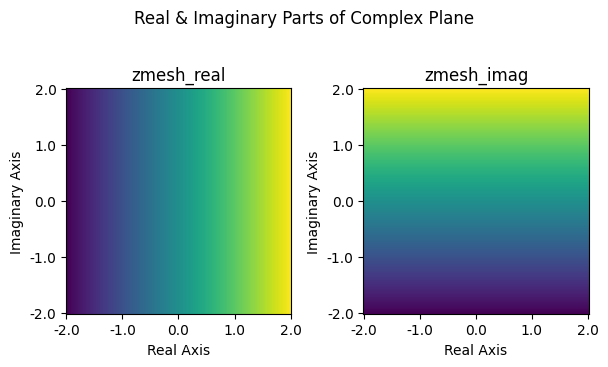

In [5]:
nb_utils.show_complex_mesh(zmesh_real, zmesh_imag)

Treat each point in the grid as the starting point for escape time calculation.  Keep plugging it through [complex-valued] `f(z) = z^2 + c` until `z`'s complex length exceeds 2.0. `c` is the main parameter that will control the fractal, hence the extra `c_real` and `c_imag` arguments for complex `c`.  Some `c`-values are boring, some lead to crazy fractals!



In [6]:
RE,IM = 0,1  # indexing into a manual complex value (i.e.  c[RE], c[IM] )

# Use the pre-computed mesh as input
def cpu_zn2plusc(np_zmesh_re, np_zmesh_im, c_real, c_imag):

    # Create output image buffer
    nr, nc = np_zmesh_re.shape
    out = np.zeros((nr, nc))
    max_escape_iter = 1000
    
    # Iterate over all pixels, using its point in the complex plane as the starting z-value
    for r in range(nr):
        for c in range(nc):
    
            # The starting z-value for pixel[r,c] is z = a + bi
            a = np_zmesh_re[r, c]
            b = np_zmesh_im[r, c]
    
            temp_real, temp_imag = 0,0
    
            for iter in range(1, max_escape_iter):
                if a*a + b*b > 4.0:
                    # Once the squared magnitude is >4.0, it's never coming back
                    break
                else:
                    # (a + bi) * (a + bi) == (a*a - b*b) + (2*a*b)i
                    temp_real = a*a - b*b + c_real
                    temp_imag = 2*a*b + c_imag
                    a = temp_real
                    b = temp_imag
    
            out[r, c] = np.log2(float(iter)) / np.log2(max_escape_iter)

    return out
    

All operations **look like** they could be vectorized, but each point requires a different number of iterations in the escape loop, so it's not as simple as just cramming together the equivalent NumPy ops from the loop.  This could clearly be optimized and probably get a sizable speedup on CPU, but we'll see it wouldn't make much of a difference compared to the GPU/CuPy version.

`c = -0.8 + 0.156i` is well-known to produce a visually pleasing fractal for f(z) = z<sup>2</sup> + c

Total time elapsed for timer cpu-fractal: 5.881 seconds


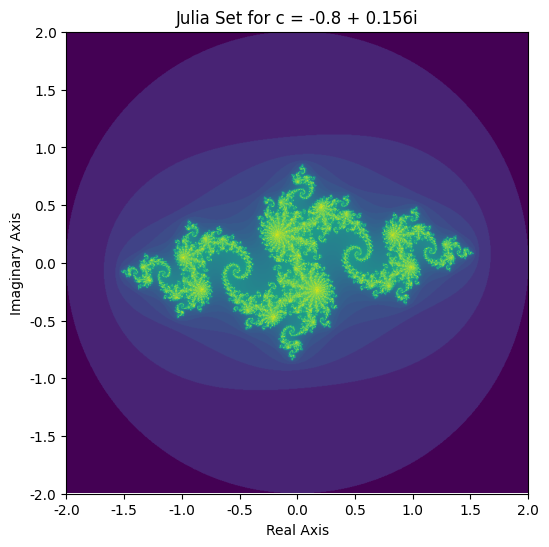

In [7]:
a, b = -0.8, 0.156
with SimpleTimers.new('cpu-fractal'):
    cpu_fractal = cpu_zn2plusc(zmesh_real, zmesh_imag, a, b)
    
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(cpu_fractal)
ax.set_title(f'Julia Set for c = -0.8 + 0.156i')
nb_utils.relabel_axes(ax)

#### Cool fractal, but it took more than <span style="color:blue">5 seconds</span> to generate one image!

-----

# 3. Julia Set Generation Code - GPU

**Notice the switch from `np` methods to nearly identical `cp` methods**

Same as before, we generate a 768x768 mesh of complex values, but using `cp` it's created directly on the GPU

In [8]:
SIZE = 768
EPS = 1e-8
zmesh_re, zmesh_im = cp.meshgrid(
    cp.arange(-2, 2+EPS, 4.0/(SIZE-1), dtype=cp.float32),
    cp.arange(-2, 2+EPS, 4.0/(SIZE-1), dtype=cp.float32))

print('X(real) mesh:', zmesh_re.device)
print('Y(imag) mesh:', zmesh_im.device)

X(real) mesh: <CUDA Device 0>
Y(imag) mesh: <CUDA Device 0>


### Define the CUDA Kernel using CuPy `ElementwiseKernel`

Everytime we run the following cell, we are generating C++ code that is compiled into a CUDA kernel and then uploaded to the GPU.  This allows downstream Python code to invoke the function on the GPU without recompiling or uploading it every time.

The meshes as the first two arguments were already created on the GPU (in the previous cell), so under the hood it's only passing the pointers to GPU memory for those inputs (not copying).  The other two arguments are simply the real and imaginary parts of the chosen `c` value.  Therefore, the only thing being sent to the GPU is a couple of GPU memory pointers and two float32 values.  It doesn't get any more efficient & optimized than that!

In [9]:
# Define the C++ code to be compiled into the CUDA grid/block kernel
gpu_escape_time_zn_plus_c = cp.ElementwiseKernel(
    'float32 z_mesh_re, float32 z_mesh_im, float32 cReal, float32 cImag',
    'float32 escape_iters',
    '''
        int time;

        float tempReal = 0.0;
        float tempImag = 0.0;

        float znReal = z_mesh_re;
        float znImag = z_mesh_im;

        for(time=1; time<1000; time++)
        {
            if(znReal*znReal + znImag*znImag > 4.0)
                break; 
            else
            {
                tempReal = znReal*znReal - znImag*znImag + cReal;
                tempImag = 2*znReal*znImag + cImag;
        
                znReal = tempReal;
                znImag = tempImag;
            }
        }
    
        escape_iters = log2f((float)time) / log2f(1000.0f);
    ''',
    'gpu_znplusc')

#### Generation Sample Fractals from GPU

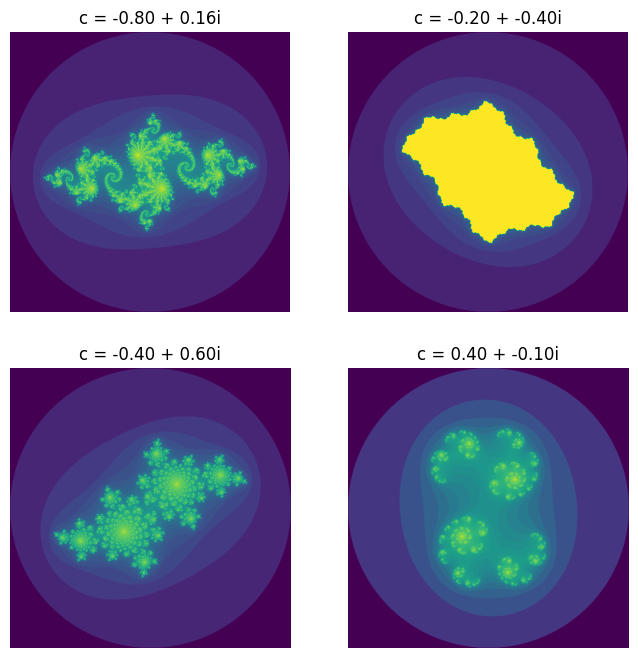

In [11]:
c_vals = [(-0.8,   0.156),
          (-0.2,  -0.4),
          (-0.4,   0.6),
          ( 0.4,  -0.1)]
          
fig,axs = plt.subplots(2,2, figsize=(8,8))
for i, (a,b) in enumerate(c_vals):
    out = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, a, b)
    axs[i//2][i%2].imshow(out.get())
    axs[i//2][i%2].set_title(f'c = {a:.2f} + {b:.2f}i')
    axs[i//2][i%2].axis('off')


## GPU Timing Tests

Timing test on GPU:

1. Compute fractals continuously leaving the result on the GPU (pure computation speed, no overhead)
1. Compute fractals, transferring each to the CPU before generating the next (more common use case)

In [12]:
# GPU timing test params
LIM = 1.0
GRID = 128

In [13]:
# This is solely for timing raw fractal computation (does not leave GPU)
print(f'GPU Timing:  {SIZE}x{SIZE} fractals; no xfer to CPU')
with SimpleTimers.new('gpu-fractal-no-xfer', n_iter=GRID*GRID):
    for j,c_re in enumerate(np.arange(-LIM, LIM, 2*(LIM + EPS) / (GRID - 1))):
        for i,c_im in enumerate(np.arange(-LIM, LIM, 2*(LIM + EPS) / (GRID - 1))):
            out = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, c_re, c_im)


GPU Timing:  768x768 fractals; no xfer to CPU
Timings (gpu-fractal-no-xfer):
  16384 iterations in 0.676 seconds
  24239.7598 iter/sec
  0.00004 sec/iter


For comparison, this is the same computation but with `.get()` on each result, which transfers the data back to the host/CPU.  We should see a dramatic performance hit, though it will still be way faster than the CPU version

In [14]:
print(f'GPU Timing:  {SIZE}x{SIZE} fractals; with overhead of xfer to CPU after each (no batching)')

host_var = None
with SimpleTimers.new('gpu-fractal-xfer-to-host', n_iter=GRID*GRID):
    for j,c_re in enumerate(np.arange(-LIM, LIM, 2*(LIM + EPS) / (GRID - 1))):
        for i,c_im in enumerate(np.arange(-LIM, LIM, 2*(LIM + EPS) / (GRID - 1))):
            host_var = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, c_re, c_im).get()

host_var = None

GPU Timing:  768x768 fractals; with overhead of xfer to CPU after each (no batching)
Timings (gpu-fractal-xfer-to-host):
  16384 iterations in 7.712 seconds
  2124.5792 iter/sec
  0.00047 sec/iter


### Speed Summary

CPU / Numpy:                         0.17 frames/sec
CPU / C++:                          10.10 frames/sec
GPU / CuPy (xfer to host):        2124.58 frames/sec
GPU / CuPy (stay on GPU):        24239.76 frames/sec

Note: C++ timing was based on a naive C++ implementation not shown here


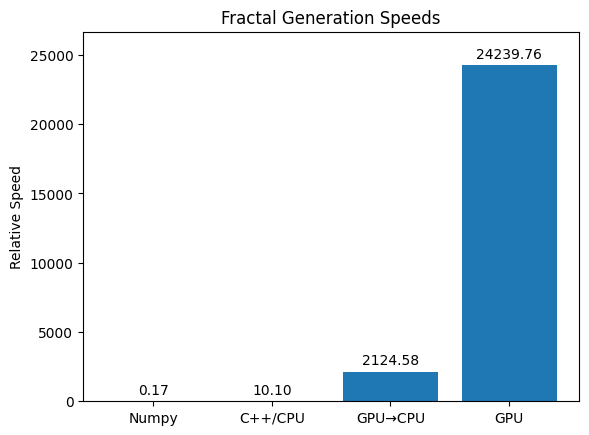

In [107]:
display_table = [ \
    ['CPU / Numpy', SimpleTimers.get_iter_per_sec('cpu-fractal')],
    ['CPU / C++', 10.1],  # from a naive C++ implementation on 768x768 fractals
    ['GPU / CuPy (xfer to host)', SimpleTimers.get_iter_per_sec('gpu-fractal-xfer-to-host')],
    ['GPU / CuPy (stay on GPU)', SimpleTimers.get_iter_per_sec('gpu-fractal-no-xfer')],
]

for txt,fps in display_table:
    print((txt+':').ljust(30), f'{fps:.2f}'.rjust(10), 'frames/sec')

print('\nNote: C++ timing was based on a naive C++ implementation not shown here')


# Data
lbls = ['Numpy', 'C++/CPU', 'GPU\u2192CPU', 'GPU']
fps = [f[1] for f in display_table]
_ = nb_utils.plot_bars_speedup(lbls, fps, 'Fractal Generation Speeds')

I really considered using a logarithmic Y-axis, but I didn't want to risk misleading anyone about the sheer insanity of the speedups achieved!

-----

# 4. Interactive Fractals!

We see that each (complex) value of `c` in `f(z) = z^2 + c` produces a different fractal:

![](https://areiner-image-share.s3.amazonaws.com/julia_set_search.png)

Since we can generate fractals so quickly, let's make an interactive fractal viewer!



In [16]:
# This really has to be defined inline in the notebook to work with mpl-interactions
class FractalExplorer:
    def __init__(self, kernel, figure, im, txt, clim=2.0, img_size=SIZE):
        self.is_pressed = False
        self.clim = clim
        self.kernel = kernel
        self.img_size = img_size
        self.figure = figure
        self.im = im
        self.txt = txt

    def connect(self):
        self.cidpress = self.figure.canvas.mpl_connect('button_press_event', self.on_press)
        self.cidrelease = self.figure.canvas.mpl_connect('button_release_event', self.on_release)
        self.cidmotion = self.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)

    def on_press(self, event):
        self.is_pressed = True
        self.on_motion(event)

    def on_motion(self, event):
        if not self.is_pressed:
            return
        
        c_re = (event.xdata / self.img_size) * (2*self.clim) - self.clim
        c_im = (event.ydata / self.img_size) * (2*self.clim) - self.clim
        self.txt.set_text(f'c = {c_re:.3f} + {-c_im:.3f}i')
        self.im.set_data(self.kernel(zmesh_re, zmesh_im, c_re, -c_im).get())
        self.im.draw()

    def on_release(self, event):
        self.is_pressed = False

    def disconnect(self):
        self.figure.canvas.mpl_disconnect(self.cidpress)
        self.figure.canvas.mpl_disconnect(self.cidrelease)
        self.figure.canvas.mpl_disconnect(self.cidmotion)
        self.figure = None
        self.im = None

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, -0.8, 0.156).get())
txt = ax.text(5, 25, c='w', s='c = -0.800 + 0.156i')
nb_utils.relabel_axes(ax)
fs = FractalExplorer(gpu_escape_time_zn_plus_c, fig, im, txt, clim=1.2)
fs.connect()

For reference, here's a few common `c`-values that produce visually-pleasing Julia Set fractals that you can try to mouse to, above:

```
(c_real, c_imag) = (-0.8, 0.16)
(c_real, c_imag) = (-0.76, 0.10)
(c_real, c_imag) = (-0.4, 0.60)
(c_real, c_imag) = (0.32, -0.5)
```

### If the above interactive fractal explorer doesn't work, here's a gif showing what it would look like
The position of the mouse pointer at a given moment is used as the c-value to generate a new fractal at that moment.  This only works so smoothly because the GPU version is so fast (and implemented via `cp.ElementwiseKernel` properly).

![](./visuals/fractal_explorer.gif)

## Create a desktop wallpaper of your fractal!

Value from mouse selection above: -0.800 + 0.156i


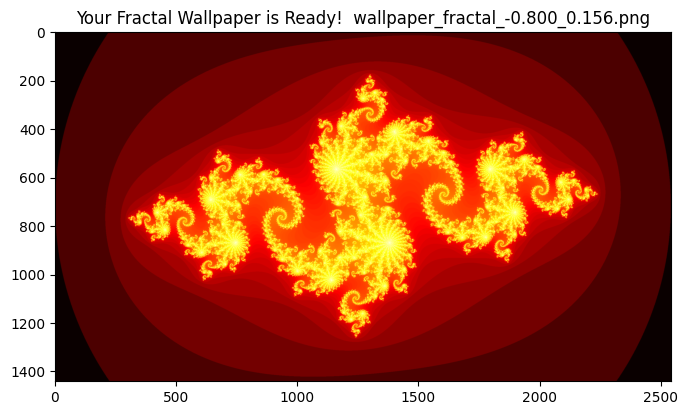

In [19]:
# Create a desktop wallpaper
size = (2540, 1440)
colormap_name = 'hot'

# Need to update our mesh creation to create custom, non-square fractals
step = 4.0 / max(size) 
lims = [s*step/2.0 for s in size]
mesh_wp_re, mesh_wp_im = cp.meshgrid(cp.arange(-lims[0], lims[0]+EPS, step, dtype=cp.float32),
                                     cp.arange(-lims[1], lims[1]+EPS, step, dtype=cp.float32))

# Get the last-chosen c-value from the text box (I had trouble doing this in more elegant ways ... ?)
txt_parts = txt.get_text().split(' ')
c_re = float(txt_parts[2])
c_im = float(txt_parts[4][:-1])
print(f'Value from mouse selection above: {c_re:.3f} + {c_im:.3f}i')

fractal = gpu_escape_time_zn_plus_c(mesh_wp_re, mesh_wp_im, c_re, c_im).get()
norm = plt.Normalize(vmin=fractal.min(), vmax=fractal.max())
image = plt.get_cmap(colormap_name)(norm(fractal))
fig,ax = plt.subplots(figsize=(8, 8 * size[1]/size[0]))
ax.imshow(image)
save_file = f'wallpaper_fractal_{c_re:.3f}_{c_im:.3f}.png'
ax.set_title(f'Your Fractal Wallpaper is Ready!  {save_file}')

# Truncate the image if it's slightly larger than intended
plt.imsave(save_file, image[:size[1], :size[0], :])


-----

------

## 5. GPU Fractal Search!

Let's take this a step further: rather than manually searching for good fractals using the mouse and our eyeballs, let's define a scoring function that is correlated with "good" fractals and search through all possible points that we would otherwise search with our mouse.

My hypothesis is that the "good" fractals have the more high-frequency components than the "bad" fractals.  So we can create a scoring function based on using CuPy's GPU-accelerated [Fast Fourier Transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform).  High density at the edges of the spectrogram indicate large frequency componenets. 

The beauty of this solution is that we can apply the FFT to the generated fractal and then compute its score, without any data leaving the GPU.  


### Simple data pipeline through the GPU

For each fractal (`c`-value), only a tiny amount of data is uploaded to the GPU to kick off the computation, then only the `float32` score is returned. 

<img src="https://areiner-fractal-resources.s3.amazonaws.com/fractal_cpu_gpu_diagram.png" width="800">

(Note: the diagram is an oversimplification, but it accurately portrays the high efficiency of the pipeline)

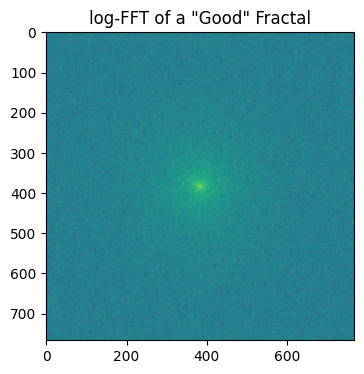

In [69]:
# Just testing that FFT works and what it looks like (CPU/Numpy)
fft_domain = np.fft.fftshift(np.fft.fft2(cpu_fractal))
fig,ax = plt.subplots(figsize=(4,4))
ax.imshow(np.log10(np.abs(fft_domain)))
_ = plt.title('log-FFT of a "Good" Fractal')

In [20]:
SIZE = 768
zmesh_re, zmesh_im = cp.meshgrid(cp.arange(-2, 2+EPS, 4.0/(SIZE-1), dtype=cp.float32),
                                 cp.arange(-2, 2+EPS, 4.0/(SIZE-1), dtype=cp.float32))

# The above meshgrid is actually resuable to compute a absolute-value-based score mask
score_mask = zmesh_re*zmesh_re + zmesh_im*zmesh_im

# "kernel" is the CuPy complex function -- we make it an input so we can repeat this for another
# fractal type, later.
def evaluate_fractal(kernel, zmesh_real, zmesh_imag, c_real, c_imag, score_mask):
    fractal = kernel(zmesh_real, zmesh_imag, c_real, c_imag)
    spectral = cp.abs(cp.fft.fftshift(cp.fft.fft2(fractal)))
    score = np.log2(cp.sum(score_mask * spectral))
    return score


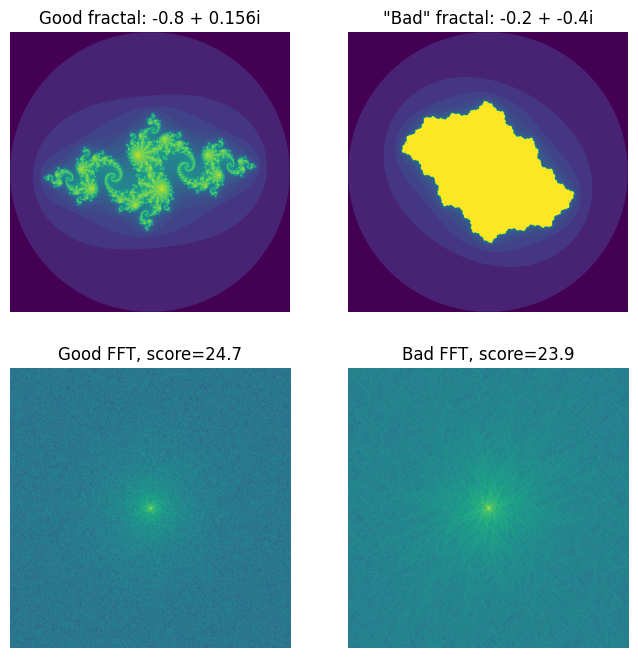

In [21]:
good_fractal = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, -0.8, 0.156)
bad_fractal = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, -0.2, -0.4)

good_log_fft = cp.log(cp.abs(cp.fft.fftshift(cp.fft.fft2(good_fractal))))
bad_log_fft = cp.log(cp.abs(cp.fft.fftshift(cp.fft.fft2(bad_fractal))))

good_score = evaluate_fractal(gpu_escape_time_zn_plus_c, zmesh_re, zmesh_im, -0.8, 0.156, score_mask)
bad_score = evaluate_fractal(gpu_escape_time_zn_plus_c, zmesh_re, zmesh_im, -0.2, -0.4, score_mask)

fig, axs =plt.subplots(2,2, figsize=(8,8))

axs[0][0].imshow(good_fractal.get())
axs[0][0].set_title('Good fractal: -0.8 + 0.156i')

axs[0][1].imshow(bad_fractal.get())
axs[0][1].set_title('"Bad" fractal: -0.2 + -0.4i')

axs[1][0].imshow(good_log_fft.get())
axs[1][0].set_title(f'Good FFT, score={good_score:.1f}')

axs[1][1].imshow(bad_log_fft.get())
axs[1][1].set_title(f'Bad FFT, score={bad_score:.1f}')

for i in range(4):
    axs[i//2][i%2].axis('off')



In absoute terms, it looks like all fractals have a lot of high-frequency components but the bad FFT has a higher concentration around the center which means more low-frequency components.  And we'll see that it's enough to produce interesting results.
   

In [22]:
LIM = 1.6
GRID = 256
STEP = 2*(LIM + EPS) / (GRID - 1)
c_map = np.zeros(shape=(GRID, GRID), dtype='float')

with SimpleTimers.new('gpu-fractal-fft-score', n_iter=GRID*GRID):
    for j,c_re in enumerate(np.arange(-LIM, LIM, STEP)):
        for i,c_im in enumerate(np.arange(-LIM, LIM, STEP)):
            c_map[i,j] = evaluate_fractal(gpu_escape_time_zn_plus_c, zmesh_re, zmesh_im, c_re, c_im, score_mask)


Timings (gpu-fractal-fft-score):
  65536 iterations in 14.055 seconds
  4662.8536 iter/sec
  0.00021 sec/iter


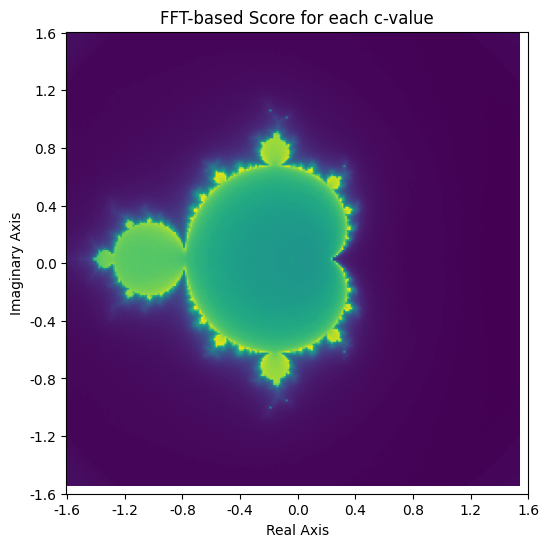

In [24]:
fig,ax = plt.subplots(figsize=(6,6))
disp_good_c_map = c_map[2:-2, 2:-2]
ax.imshow(disp_good_c_map)

ax.set_title('FFT-based Score for each c-value')
nb_utils.relabel_axes(ax, nr=256, ni=256, rmin=-1.6, rmax=1.6, imin=-1.6, imax=1.6)

## The Good-Fractal Map is ... a fractal ?!
It turns out that the map of `c`-values that produce high quality fractals is another fractal!  Specifically, it's the **Mandelbrot set**.  Here's a high-res version from wikipedia.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Mandel_zoom_00_mandelbrot_set.jpg/322px-Mandel_zoom_00_mandelbrot_set.jpg)

(Source: From Wikipedia)

Might as well check the fractal at the point with the most high-frequency...

C-value map: (256, 256)


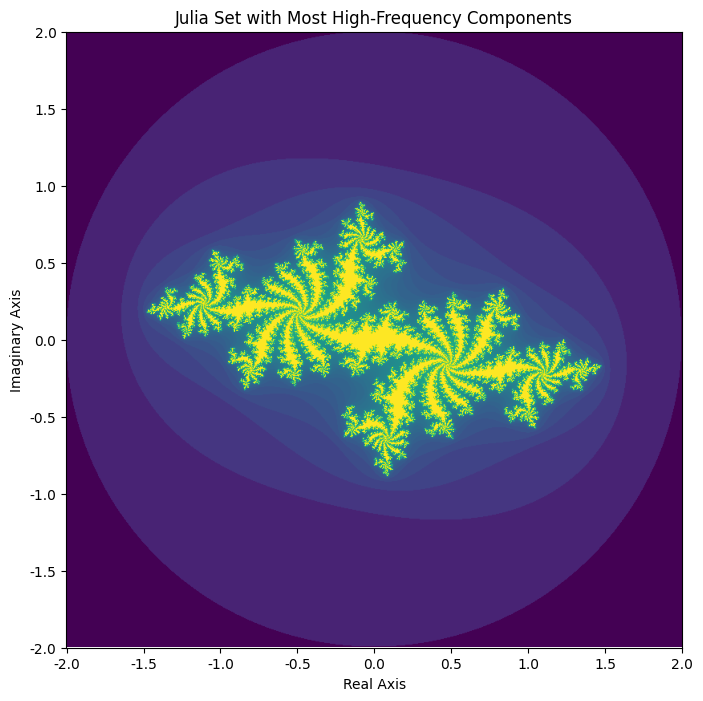

In [26]:
print('C-value map:', c_map.shape)
lin_max = np.argmax(c_map)
j, i = lin_max // GRID, lin_max % GRID
highest_freq_fractal = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, -LIM+i*STEP, -LIM+j*STEP)
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(highest_freq_fractal.get())
ax.set_title('Julia Set with Most High-Frequency Components')
nb_utils.relabel_axes(ax)


-----
## Cubic Fractal

Another common fractal is f(z) = z<sup>3</sup> + c

We should be able to define it the same way and repeat the search.

In [27]:

max_iter_escape = 1000
gpu_escape_time_zn3plusc = cp.ElementwiseKernel(
        'float32 mesh_re, float32 mesh_im, float32 cReal, float32 cImag',
        'float32 out',
        f'''
            int time = 0;

            float tempReal = 0.0;
            float tempImag = 0.0;

            float a = mesh_re;
            float b = mesh_im;
            float magnitude = 0.0;

            for(time=1; time<{max_iter_escape}; time++)
            {{
                magnitude = a*a + b*b;
                if(magnitude < 4.0)
                {{
                    tempReal = a*a*a - 3*a*b*b + cReal;
                    tempImag = 3*a*a*b - b*b*b + cImag;
            
                    a = tempReal;
                    b = tempImag;
                }}
                else
                    break;
            }}
        
            out = log2f((float)time) / log2f((float){max_iter_escape});
        ''',
        'escape_time_zn3minus1')

Equation: z<sup>3</sup> + c

Some good looking values:
```
c ==  0.470 - 0.580i
c == -0.560 + 0.230i
c == -0.550 + 0.292i
c ==  0.535 - 0.378i
c == -0.465 - 0.028i
```

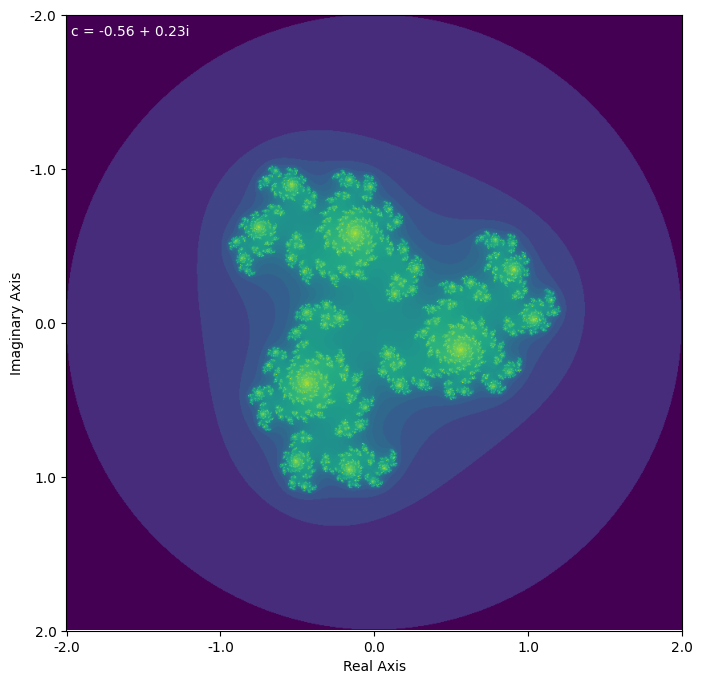

In [28]:

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(gpu_escape_time_zn3plusc(zmesh_re, zmesh_im, -0.56, 0.23).get())
txt = ax.text(5, 25, c='w', s='c = -0.56 + 0.23i')
ax.set_xticks(np.arange(0, SIZE+1, SIZE//4))
ax.set_xticklabels(np.arange(-2, 2+EPS, 1))
ax.set_yticks(np.arange(0, SIZE+1, SIZE//4))
ax.set_yticklabels(np.arange(-2, 2+EPS, 1))
ax.set_xlabel('Real Axis')
ax.set_ylabel('Imaginary Axis')
fs3 = FractalExplorer(gpu_escape_time_zn3plusc, fig, im, txt, clim=1.0)
fs3.connect()

Value from mouse selection above: -0.560 + 0.230i


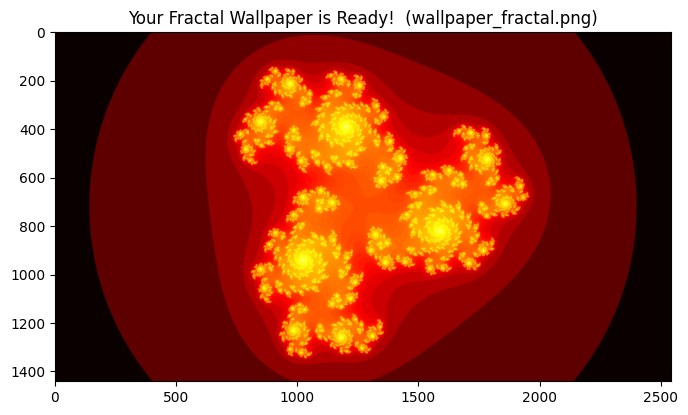

In [97]:
size = (2540, 1440)
colormap_name = 'hot'

step = 4.5 / max(size) 
lims = [s*step/2.0 for s in size]
offs = 0.0  # shifts the window vertical due to cubic fractals being vertically skewed
zmesh_wp_re, zmesh_wp_im = cp.meshgrid(cp.arange(-lims[0], lims[0]+EPS, step, dtype=cp.float32),
                                     cp.arange(-lims[1]-offs, lims[1]+EPS, step, dtype=cp.float32))

# Get the last-chosen c-value from the text box (I had trouble doing this other ways ... ?)
txt_parts = txt.get_text().split(' ')
c_re = float(txt_parts[2])
c_im = float(txt_parts[4][:-1])
print(f'Value from mouse selection above: {c_re:.3f} + {c_im:.3f}i')

fractal = gpu_escape_time_zn3plusc(zmesh_wp_re, zmesh_wp_im, c_re, c_im).get()
norm = plt.Normalize(vmin=fractal.min(), vmax=fractal.max())
image = plt.get_cmap(colormap_name)(norm(fractal))
fig,ax = plt.subplots(figsize=(8, 8 * size[1]/size[0]))
ax.imshow(image)
ax.set_title('Your Fractal Wallpaper is Ready!  (wallpaper_fractal.png)')
plt.imsave('wallpaper_fractal_zn3p1.png', image[:size[1], :size[0], :])

## "Good Fractal Map" for the z<sup>3</sup> + c Variant

In [30]:
z3_c_map = np.zeros(shape=(GRID, GRID), dtype='float')

t_start = time.time()
for j,c_re in enumerate(np.arange(-LIM, LIM, 2*(LIM + EPS) / (GRID - 1))):
    for i,c_im in enumerate(np.arange(-LIM, LIM, 2*(LIM + EPS) / (GRID - 1))):
        z3_c_map[i,j] = evaluate_fractal(gpu_escape_time_zn3plusc, zmesh_re, zmesh_im, c_re, c_im, score_mask)

print(f'Evaluated {GRID*GRID:,d} in {time.time()-t_start:.1f} seconds')
time_per_fractal = (time.time() - t_start) / (GRID * GRID)
print(f'GPU - Time to compute each {SIZE}x{SIZE} fractal, FFT, reduce: {time_per_fractal:.4f} sec')

Evaluated 65,536 in 14.8 seconds
GPU - Time to compute each 768x768 fractal, FFT, reduce: 0.0002 sec


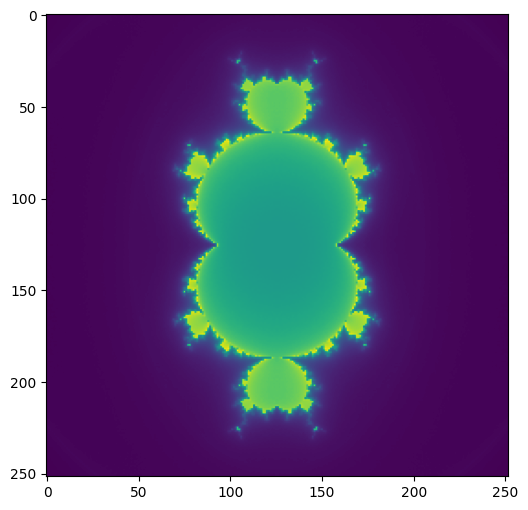

In [31]:
fig,ax = plt.subplots(figsize=(6,6))
z3_disp_good_c_map = z3_c_map[2:-2, 2:-2]
ax.imshow(z3_disp_good_c_map)


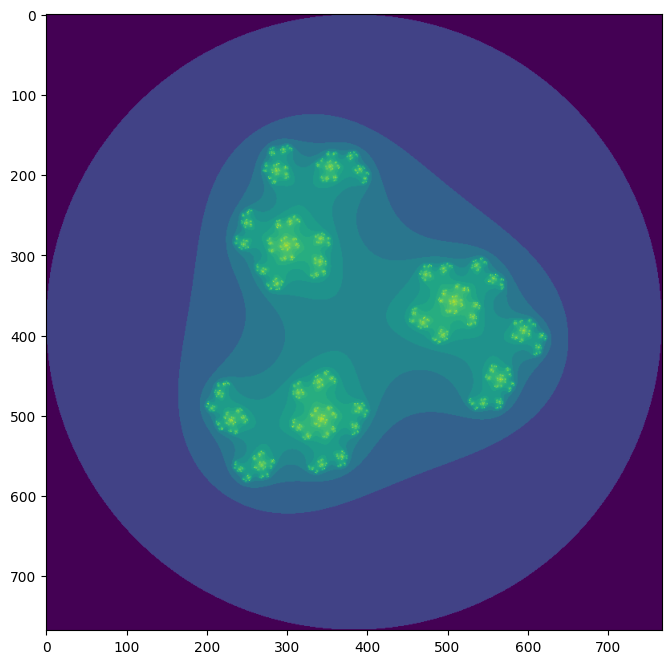

In [32]:
lin_max = np.argmax(c_map)
j, i = lin_max // GRID, lin_max % GRID
highest_freq_fractal = gpu_escape_time_zn3plusc(zmesh_re, zmesh_im, -LIM+i*STEP, -LIM+j*STEP)
fig,ax = plt.subplots(figsize=(8,8))
_ = ax.imshow(highest_freq_fractal.get())

-----

-----

## Writing CPU/GPU-Agnostic Code

The following code shows how we can use `cp.get_array_module(x)` to get the correct module (`np` or `cp`) depending on whether the input `x` is a Numpy or CuPy array.  We use `xp` to represent whichever module it is, and then use standard Numpy methods that are available in both modules. We demonstrate that it works by doing a FFT speed test.


Timings (numpy-fft):
  100 iterations in 1.722 seconds
  58.0749 iter/sec
  0.01722 sec/iter
Timings (cupy-fft):
  100 iterations in 0.005 seconds
  19397.4194 iter/sec
  0.00005 sec/iter
GPU Speedup for 1024x1024 FFTs: 334.01


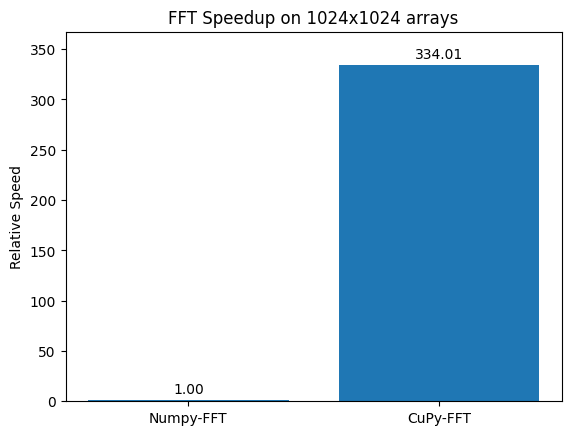

In [38]:
num_test = 100
size = 1024

def test_fft_module(random_input, n_test):
    xp = cp.get_array_module(random_input) 
    modname = str(xp).split(' ')[1].strip('"\'')
    
    with SimpleTimers.new(f'{modname}-fft', n_iter=n_test):
        for i in range(n_test):
            out = xp.fft.fft2(random_input[i, :, :])
    
test_fft_module(np.random.uniform(size=(num_test, size, size)), num_test)
test_fft_module(cp.random.uniform(size=(num_test, size, size)), num_test)

cpu_speed = SimpleTimers.get_iter_per_sec('numpy-fft')
gpu_speed = SimpleTimers.get_iter_per_sec('cupy-fft')
speed_ratio = gpu_speed / cpu_speed
print(f'GPU Speedup for {size}x{size} FFTs: {speed_ratio:.2f}')

nb_utils.plot_bars_speedup(['Numpy-FFT', 'CuPy-FFT'], [1, speed_ratio], f'FFT Speedup on {size}x{size} arrays')

If you are writing a full script that should work with either module, you can do something like the following:

In [36]:
try:
    import cupy as xp
    using_gpu = True
except:
    import numpy as xp
    using_gpu = False
    
zmesh_re, zmesh_im = xp.meshgrid(xp.arange(-2, 2, 0.01), xp.arange(-2, 2, 0.01))
fft_out = xp.fft.fft2(zmesh_re)
print('Initial FFT output type:', str(type(fft_out)))
if using_gpu:
    fft_out = fft_out.get() # this pulls result from GPU mem to CPU/Numpy
      
print('Final FFT output type:  ', str(type(fft_out)))
    

Initial FFT output type: <class 'cupy.ndarray'>
Final FFT output type:   <class 'numpy.ndarray'>


-----
# BONUS EXERCISE: Zooming Julia Sets

Let's create a zooming Julia set animation like the Mandelbrot set animation [from Wikipedia](https://en.wikipedia.org/wiki/Mandelbrot_set).  I could use the exact same code as before, except it was only defined for `float32` which might limit our maximum zoom.  I will change the kernel to use `T` as the datatype which is CuPy's way of saying "use the datatype of the arguments passed in".  Then I will use a `float64` mesh as the input instead of `float32`.

NOTE: The fractal generation for each image is almost instantaneous, but the rendering and saving to file is what takes forever.  Actually it's worth than that, it appears to by O(N^2) to generation N-frames, probably the way I'm generating matplotlib displays for each frame.  But it gets the job done.

In [88]:
# Define the C++ code to be compiled into the CUDA grid/block kernel
gpu_escape_time_zn_plus_c_64bit = cp.ElementwiseKernel(
    'T z_mesh_re, T z_mesh_im, T cReal, T cImag',
    'T escape_iters',
    '''
        int time;

        T tempReal = 0.0;
        T tempImag = 0.0;

        T znReal = z_mesh_re;
        T znImag = z_mesh_im;

        for(time=1; time<1000; time++)
        {
            if(znReal*znReal + znImag*znImag > 4.0)
                break; 
            else
            {
                tempReal = znReal*znReal - znImag*znImag + cReal;
                tempImag = 2*znReal*znImag + cImag;
        
                znReal = tempReal;
                znImag = tempImag;
            }
        }
    
        escape_iters = log2((T)time) / log2(1000.0);
    ''',
    'gpu_znplusc')

In [89]:
import shutil
import os

temp_dir = './julia_zoom'
if os.path.isdir(temp_dir):
    shutil.rmtree(temp_dir)
    
os.makedirs(temp_dir, exist_ok=True)
   

In [ ]:
num_zoom_frames = 300
img_size = 1.5
zoom_speed = 1.05

zoom_center_re = -0.43
zoom_center_im = 0.122
c_re = -0.8
c_im = 0.156

all_fractal_files = []
fig,ax = plt.subplots(figsize=(8,8))
for f in range(num_zoom_frames):
    lft = zoom_center_re - img_size
    rgt = zoom_center_re + img_size
    bot = zoom_center_im - img_size
    top = zoom_center_im + img_size
    zmesh_re, zmesh_im = cp.meshgrid(
        cp.arange(lft, rgt+EPS, (img_size*2)/(SIZE-1), dtype=cp.float64),
        cp.arange(bot, top+EPS, (img_size*2)/(SIZE-1), dtype=cp.float64))
    
    out = gpu_escape_time_zn_plus_c_64bit(zmesh_re, zmesh_im, c_re, c_im)
    all_fractals.append(out.get())

    ax.imshow(out.get(), cmap='hot')
    ax.axis('off')
    all_fractal_files.append(os.path.join(temp_dir, f'fractal_{f:04d}.png'))
    plt.savefig(all_fractal_files[-1], bbox_inches='tight',transparent=True, pad_inches=0)
        
    img_size = img_size / zoom_speed

In [ ]:
fractal_images = [imageio.imread(file) for file in all_fractal_files]
imageio.mimsave('visuals/julia_zoom.gif', fractal_images, duration=1000/15, loop=0)

### Julia Set Zoom Animation
![](visuals/julia_zoom.gif)